In [79]:
import pandas as pd
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [80]:
# 替换成你的Excel文件路径
file_path = "高炉数据原件 - 副本.xlsx"

# 读取Excel文件
df_tieshui = pd.read_excel(file_path, sheet_name='铁水质量')
df_temp = pd.read_excel(file_path, sheet_name='铁水温度')
df_params = pd.read_excel(file_path, sheet_name='主参数')



In [81]:
df_temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16741 entries, 0 to 16740
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   时间      16741 non-null  datetime64[ns]
 1   铁水温度    16741 non-null  int64         
 2   铁口编号    16741 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 392.5+ KB


In [82]:
# 使用rename方法修改列名
df_tieshui.rename(columns={'化验时间': '铁水时间戳'}, inplace=True)
df_temp.rename(columns={'时间': '温度时间戳'}, inplace=True)
df_params.rename(columns={'时间': '主参数时间戳'}, inplace=True)


In [83]:
# 定义起始时间
start_time ='2023-02-09 00:00:00'
start_time_stamp = pd.Timestamp(start_time).timestamp()

# 转换为时间戳并保存到新列
tieshui_timestamp  = df_tieshui.iloc[:, 0].apply(lambda x: pd.Timestamp(x).timestamp())
temp_timestamp  = df_temp.iloc[:, 0].apply(lambda x: pd.Timestamp(x).timestamp())
params_timestamp  = df_params.iloc[:, 0].apply(lambda x: pd.Timestamp(x).timestamp())

# 在后续步骤中使用新列进行进一步的操作
sampling_time = 3600
df_tieshui['铁水时间戳']  = (tieshui_timestamp - start_time_stamp) / sampling_time
df_temp['温度时间戳']     = (temp_timestamp - start_time_stamp) / sampling_time
df_params['主参数时间戳'] = (params_timestamp - start_time_stamp) / sampling_time
df_temp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16741 entries, 0 to 16740
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   温度时间戳   16741 non-null  float64
 1   铁水温度    16741 non-null  int64  
 2   铁口编号    16741 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 392.5+ KB


In [84]:
# 将 '铁水温度' 和 '时间' 列按照 '铁口编号' 分组
grouped_temp = df_temp.groupby('铁口编号')[['温度时间戳', '铁水温度']]

# 创建三个新的DataFrame，用于存储拆分后的数据
df_tieko1 = pd.DataFrame()
df_tieko2 = pd.DataFrame()
df_tieko3 = pd.DataFrame()

# 遍历每个铁口的分组
for tieko, group in grouped_temp:
    # 重置索引并添加到相应的新DataFrame中
    group = group.reset_index(drop=True)
    
    if tieko == '铁口1':
        df_tieko1[['铁口1时间戳', '铁口1温度']] = group
    elif tieko == '铁口2':
        df_tieko2[['铁口2时间戳', '铁口2温度']] = group
    elif tieko == '铁口3':
        df_tieko3[['铁口3时间戳', '铁口3温度']] = group

# 打印新的DataFrame的信息
# print("铁口1温度:")
# print(df_tieko1.info())

# print("\n铁口2温度:")
# print(df_tieko2.info())

# print("\n铁口3温度:")
# print(df_tieko3.info())

# 合并三个DataFrame
df_tiekou = pd.concat([df_tieko1, df_tieko2, df_tieko3], axis=1)
df_tiekou.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   铁口1时间戳  7216 non-null   float64
 1   铁口1温度   7216 non-null   float64
 2   铁口2时间戳  2018 non-null   float64
 3   铁口2温度   2018 non-null   float64
 4   铁口3时间戳  7507 non-null   float64
 5   铁口3温度   7507 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 352.0 KB


In [85]:
# 合并三个DataFrame
df_combined = pd.concat([df_tieshui, df_tiekou, df_params], axis=1)
# 打印或保存结果
df_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16252 entries, 0 to 16251
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   铁水时间戳   16252 non-null  float64
 1   P       16252 non-null  float64
 2   S       16252 non-null  float64
 3   MN      16252 non-null  float64
 4   SI      16252 non-null  float64
 5   V       16252 non-null  float64
 6   TI      16252 non-null  float64
 7   As      16252 non-null  float64
 8   铁口1时间戳  7216 non-null   float64
 9   铁口1温度   7216 non-null   float64
 10  铁口2时间戳  2018 non-null   float64
 11  铁口2温度   2018 non-null   float64
 12  铁口3时间戳  7507 non-null   float64
 13  铁口3温度   7507 non-null   float64
 14  主参数时间戳  7453 non-null   float64
 15  富氧率     7453 non-null   float64
 16  透气性指数   7453 non-null   float64
 17  CO      7453 non-null   float64
 18  H2      7453 non-null   float64
 19  CO2     7453 non-null   float64
 20  标准风速    7453 non-null   float64
 21  富氧流量    7453 non-null   float64
 22

In [86]:
df_combined.columns


Index(['铁水时间戳', 'P', 'S', 'MN', 'SI', 'V', 'TI', 'As', '铁口1时间戳', '铁口1温度',
       '铁口2时间戳', '铁口2温度', '铁口3时间戳', '铁口3温度', '主参数时间戳', '富氧率', '透气性指数', 'CO',
       'H2', 'CO2', '标准风速', '富氧流量', '冷风流量', '鼓风动能', '炉腹煤气量', '炉腹煤气指数',
       '理论燃烧温度', '顶压', '富氧压力', '冷风压力', '全压差', '热风压力', '实际风速', '热风温度', '顶温东北',
       '顶温西南', '顶温西北', '顶温东南', '阻力系数', '鼓风湿度', '设定喷煤量', '上小时喷煤量'],
      dtype='object')

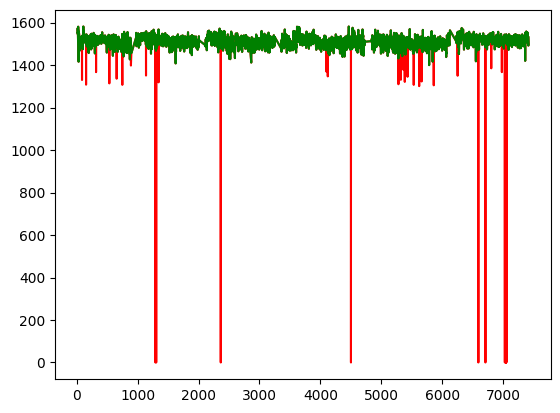

In [87]:
import numpy as np

# 异常数据处理
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_combined.copy()

# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 检测异常值的索引
    outliers_index = y.abs() < 1400.0  # 使用固定阈值，你可以根据实际情况调整
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value

# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_process['铁口1时间戳'], df_sheet_process['铁口1温度'])

# 绘图
plt.plot(df_combined['铁口1时间戳'], df_combined['铁口1温度'], 'r')
plt.plot(df_sheet_process['铁口1时间戳'], df_sheet_process['铁口1温度'], 'g')



In [89]:
# 将 df_combined 添加到新的 ExcelWriter 中
with pd.ExcelWriter("数据-时间戳.xlsx", engine='xlsxwriter') as writer:
    # 将其他 sheet 写入新文件
    df_combined.to_excel(writer, sheet_name='Sheet1', index=False)
    df_sheet_process.to_excel(writer, sheet_name='Sheet2', index=False)


In [ ]:
print(df_combined.columns)
